<a href="https://colab.research.google.com/github/home0712/CMSC320/blob/main/Final_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U.S. Economy's Impact on Music Trends: 2006-2022 Analysis
Minji Kim

## Introduction
Music, an ever-evolving reflection of society, is more than just a form of entertainment; it is a cultural and historical record of the times in which it is created. From the protest songs of the '60s to the economic blues of the Great Depression era, music has always served as a barometer for societal sentiment, capturing the joys, sorrows, aspirations, and challenges of each generation.

On the other hand, the economy, a complex web of transactions and relationships, profoundly impacts every aspect of human life, including culture and the arts. The ebb and flow of economic tides, marked by GDP fluctuations and unemployment rates, not only determine the purchasing power and lifestyle choices of individuals but also influence the themes, production, and consumption of music. For instance, in periods of economic prosperity, music might lean towards themes of abundance, celebration, and optimism, while downturns may yield sounds of introspection, resilience, and hope.

Understanding the intricate dance between music trends and economic indicators can offer valuable insights into both the direct and indirect ways in which macroeconomic conditions shape cultural output. This relationship is crucial, as it reveals how the collective consciousness, as expressed through music, responds to and reflects broader economic realities. By delving into this analysis from 2006 to 2022, we aim to capture a snapshot of a transformative era, exploring the harmony and discord between the U.S. economy and its musical landscape.



## Data Collection & Processing: Music Data
### Setup
Install the necessary libraries

In [ ]:
!pip install billboard.py pandas spotipy

In [ ]:
# data collection
import billboard
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import re
import urllib.parse
import pandas as pd


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# hypothesis testing
from scipy.stats import pearsonr

# machine learning
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


### Use [billboard.py](https://github.com/guoguo12/billboard-charts) to Fetch Songs
The initial step in my analysis involves gathering data from the [Billboard Year-End Hot 100](https://www.billboard.com/charts/year-end/) charts spanning the years 2006 to 2022. The Hot 100 chart represents a compilation of the year's most popular songs from all genres. Rankings are determined by streaming activity sourced from digital platforms monitored by Luminate, radio airplay audience impressions provided by Luminate, and sales data compiled by the same entity. This chart details both the song title and the corresponding artist.

In [ ]:
def get_year_end_songs(year):
    chart_name = 'hot-100-songs'
    chart = billboard.ChartData(f'{chart_name}', year=year)
    songs = [{"title": song.title, "artist": song.artist, "year": year} for song in chart]
    return songs

### Setup [Spotify API](https://spotipy.readthedocs.io/en/2.22.1/) & Add the Genre Column
While both the billboard.py library and the Billboard website lack genre information, I turn to the Spotify API to enrich my dataframe with a genre column. Given potential discrepancies in the formatting of song titles and artist names between Billboard and Spotify, I've introduced a function, clean_artist_name, to harmonize the artist data from Billboard, ensuring it highlights the main artist's name. With the song titles sourced from billboard.py and the streamlined artist names from our function, I proceed to develop a separate function dedicated to seamlessly integrating the genre column.

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = '92b8fcb838ea4e97b6a8ebb14b8b7ef4'
client_secret = 'Secret_Key'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
def clean_artist_name(artist):
    pattern = re.compile(r' Featuring | x | X | & | \+ | \/ |, | With | Duet With ')
    primary_artist = re.split(pattern, artist)[0].strip()
    return primary_artist

def add_genres_to_songs(songs):
    for song in songs:
        # Escaping characters for URL
        song_title = urllib.parse.quote(song['title'])

        cleaned_artist = clean_artist_name(song['artist'])
        results = sp.search(q=f"track:{song_title} artist:{cleaned_artist}", type="track", limit=1)

        if results["tracks"]["items"]:
            track = results["tracks"]["items"][0]
            artist_id = track["artists"][0]["id"]
            artist_details = sp.artist(artist_id)

            song["genre"] = ", ".join(artist_details["genres"])
        else:
            song["genre"] = "Unknown"
    return songs

In [ ]:
years = range(2006, 2023)
all_songs = []

for year in years:
    songs_for_year = get_year_end_songs(year)
    all_songs.extend(add_genres_to_songs(songs_for_year))

df_all_songs_initial = pd.DataFrame(all_songs)
df_all_songs_initial.head()

In my efforts to ensure completeness of data through specialized functions, I still encountered "unknown" entries in the genre column. To rectify these gaps, I turned to an xlsx file to manually input the relevant genre data. Additionally, mindful of the rate limit imposed by the Spotify API, I opted to preserve the refined dataframe by saving it as a CSV file, facilitating easier subsequent use.

In [ ]:
filename = "billboard_songs.xlsx"
df_all_songs_initial.to_excel(filename, index=False, engine='openpyxl')

In [ ]:
url = "https://raw.githubusercontent.com/MinJi-Kim710/data/main/billboard_songs.xlsx%20-%20Sheet1.csv"
df_all_songs = pd.read_csv(url)

df_all_songs.head()

,title,artist,year,genre
0,Bad Day,Daniel Powter,2006,"canadian pop, neo mellow, pop rock"
1,Temperature,Sean Paul,2006,"dance pop, dancehall, pop, pop rap"
2,Promiscuous,Nelly Furtado Featuring Timbaland,2006,"canadian latin, canadian pop, dance pop, pop"
3,You're Beautiful,James Blunt,2006,"neo mellow, pop rock"
4,Hips Don't Lie,Shakira Featuring Wyclef Jean,2006,"colombian pop, dance pop, latin pop, pop"


Additionally, the "artist" column contains multiple data entries, so I separate them individually. I've created a new column, "split_artist", to store the separated data.

In [ ]:
def split_artists(artist):
    delimiters = [" & ", " x ", " X ", " With ", " Featuring ", " Duet With ", " + ", "/", ","]
    for delimiter in delimiters:
        if delimiter in artist:
            return [artist.strip() for artist in artist.split(delimiter)]
    return [artist]  # if no delimiter is found, return the artist string as a list

In [ ]:
df_all_songs['split_artist'] = df_all_songs['artist'].apply(split_artists)

# Explode this new column to have separate rows for each artist
df_split_artist = df_all_songs.explode('split_artist')
df_split_artist.head()

,title,artist,year,genre,split_artist
0,Bad Day,Daniel Powter,2006,"canadian pop, neo mellow, pop rock",Daniel Powter
1,Temperature,Sean Paul,2006,"dance pop, dancehall, pop, pop rap",Sean Paul
2,Promiscuous,Nelly Furtado Featuring Timbaland,2006,"canadian latin, canadian pop, dance pop, pop",Nelly Furtado
2,Promiscuous,Nelly Furtado Featuring Timbaland,2006,"canadian latin, canadian pop, dance pop, pop",Timbaland
3,You're Beautiful,James Blunt,2006,"neo mellow, pop rock",James Blunt


Lastly, the following dataframe will be used for data visualization. Since the "genre" column contains multiple entries, I will divide these into individual rows.

In [ ]:
# Convert the "genre" column into a list of genres
df_all_songs['genre'] = df_all_songs['genre'].str.split(', ')

# Explode the "genre" column to create separate rows for each genre
df_split_genre = df_all_songs.explode('genre')
df_split_genre.head()

,title,artist,year,genre,split_artist
0,Bad Day,Daniel Powter,2006,canadian pop,[Daniel Powter]
0,Bad Day,Daniel Powter,2006,neo mellow,[Daniel Powter]
0,Bad Day,Daniel Powter,2006,pop rock,[Daniel Powter]
1,Temperature,Sean Paul,2006,dance pop,[Sean Paul]
1,Temperature,Sean Paul,2006,dancehall,[Sean Paul]


### Add the Mood Column
Tracks with high valence resonate with more upbeat emotions, such as happiness, cheerfulness, and joy. In contrast, those with low valence convey more somber feelings, like sadness, depression, or anger. A standout feature of the Spotify API is its capacity to quantify [a song's valence](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Leveraging this, I distinguished the songs' moods into three distinct categories: happy, neutral, and sad, and subsequently introduced a "mood" column to reflect these classifications. Upon eliminating rows with redundant titles, the df_all_songs dataframe now prominently features an added "mood" column.

In [ ]:
def get_mood(artist, track):
    results = sp.search(q=f'track:{track} artist:{artist}', type="track", limit=1)

    # Check if results were returned
    if not results['tracks']['items']:
        return None

    track_id = results['tracks']['items'][0]['id']

    # Fetch audio features
    audio_features = sp.audio_features(track_id)[0]

    if not audio_features:
        return None

    valence = audio_features.get('valence')
    if valence is None:
        return None

    # Classify mood based on valence
    if valence >= 0.7:
        return "Happy"
    elif 0.4 <= valence < 0.7:
        return "Neutral"
    else:
        return "Sad"

In [ ]:
# Add a mood column
df_split_artist['mood'] = df_split_artist.apply(lambda row: get_mood(row['split_artist'], row['title']), axis=1)

# Remove duplicates based on 'title' column
df_cleaned = df_split_artist.drop_duplicates(subset='title', keep='first')
df_cleaned.head()

Echoing previous steps, I used an xlsx file to manually supplement the dataframe with missing mood data. Additionally, due to the rate limit imposed by the Spotify API, I opted to store the updated dataframe in a CSV format for ease of future access.

In [ ]:
filename = "billboard_songs_with_mood.xlsx"
df_cleaned.to_excel(filename, index=False, engine='openpyxl')

In [ ]:
url = "https://raw.githubusercontent.com/MinJi-Kim710/data/main/billboard_songs_with_mood.csv"
df_music = pd.read_csv(url)

df_music.head()

,title,artist,year,genre,mood
0,Temperature,Sean Paul,2006,"['dance pop', 'dancehall', 'pop', 'pop rap']",Happy
1,Promiscuous,Nelly Furtado Featuring Timbaland,2006,"['canadian latin', 'canadian pop', 'dance pop'...",Happy
2,Hips Don't Lie,Shakira Featuring Wyclef Jean,2006,"['colombian pop', 'dance pop', 'latin pop', 'p...",Happy
3,Ridin',Chamillionaire Featuring Krayzie Bone,2006,"['dirty south rap', 'southern hip hop']",Happy
4,SexyBack,Justin Timberlake,2006,"['dance pop', 'pop']",Happy


## Data Collection & Processing: Economic Data
In my exploration of the U.S. economy's influence on music trends, I compiled a CSV file using [the GDP Growth Rate](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=US) (%) in the United States data from The World Bank, along with [the U.S. Unemployment Rate data](https://www.macrotrends.net/countries/USA/united-states/unemployment-rate).

In [ ]:
url = "https://raw.githubusercontent.com/MinJi-Kim710/data/main/USA_GDP_Unemployment.csv"
df_economy = pd.read_csv(url)

df_economy.head()

,year,GDP growth (%),unemployment Rate (%)
0,2006,2.782811,4.62
1,2007,2.010508,4.62
2,2008,0.122188,5.78
3,2009,-2.599888,9.25
4,2010,2.708857,9.63


# Data Visualization

## Genre Popularity
The ebb and flow of musical genres provide a compelling narrative about cultural shifts and evolving tastes over time. From 2006 to 2022, I sought to visually represent these dynamic changes in genre popularity to discern patterns or cyclical tendencies in musical preferences. Recognizing the potential complexities and nuances of numerous sub-genres, I made a deliberate choice to streamline this representation. To ensure clarity and focus, sub-genres like alternative hip hop and conscious hip hop were merged into their overarching genre – in this case, hip hop. This consolidation is reflected in the "broad_genre" column, simplifying the data for a clearer, more comprehensive view of the musical landscape's evolution.

In [ ]:
# List all genres
exploded_genres = df_split_genre['genre'].str.split(', ').explode()
unique_genres = exploded_genres.unique()
genre_list = list(unique_genres)
genre_list.sort()
print(genre_list)

['acoustic pop', 'adult standards', 'afro r&b', 'afrobeats', 'afrofuturism', 'afropop', 'alabama rap', 'alt z', 'alternative dance', 'alternative hip hop', 'alternative metal', 'alternative r&b', 'alternative rock', 'american folk revival', 'arkansas hip hop', 'art pop', 'art rock', 'asian american hip hop', 'atl hip hop', 'atl trap', 'australian country', 'australian dance', 'australian electropop', 'australian hip hop', 'australian indie', 'australian pop', 'azonto', 'azontobeats', 'barbadian pop', 'baroque pop', 'baton rouge rap', 'bedroom pop', 'bedroom soul', 'big room', 'black americana', 'blues rock', 'boy band', 'british soul', 'bronx hip hop', 'brooklyn drill', 'brostep', 'cali rap', 'canadian contemporary r&b', 'canadian hip hop', 'canadian latin', 'canadian old school hip hop', 'canadian pop', 'canadian rock', 'canadian trap', 'candy pop', 'cartoon', 'ccm', 'celtic rock', 'chicago bop', 'chicago drill', 'chicago rap', 'chicano rap', "children's music", 'christian alternative

In [ ]:
genre_mapping = {
    'acoustic pop': 'Pop',
    'adult standards': 'Pop',
    'afro r&b': 'R&B',
    'afrobeats': 'World Music',
    'afrofuturism': 'World Music',
    'afropop': 'World Music',
    'alabama rap': 'Hip Hop',
    'alt z': 'Alternative',
    'alternative dance': 'Alternative',
    'alternative hip hop': 'Hip Hop',
    'alternative metal': 'Metal',
    'alternative r&b': 'R&B',
    'alternative rock': 'Rock',
    'american folk revival': 'Folk',
    'arkansas hip hop': 'Hip Hop',
    'art pop': 'Pop',
    'art rock': 'Rock',
    'asian american hip hop': 'Hip Hop',
    'atl hip hop': 'Hip Hop',
    'atl trap': 'Hip Hop',
    'australian country': 'Country',
    'australian dance': 'Dance',
    'australian electropop': 'Electronica',
    'australian hip hop': 'Hip Hop',
    'australian indie': 'Indie',
    'australian pop': 'Pop',
    'azonto': 'World Music',
    'azontobeats': 'World Music',
    'barbadian pop': 'Pop',
    'baroque pop': 'Pop',
    'baton rouge rap': 'Hip Hop',
    'bedroom pop': 'Pop',
    'bedroom soul': 'R&B',
    'big room': 'Electronica',
    'black americana': 'Americana',
    'blues rock': 'Rock',
    'boy band': 'Pop',
    'british soul': 'Soul',
    'bronx hip hop': 'Hip Hop',
    'brooklyn drill': 'Hip Hop',
    'brostep': 'Electronica',
    'cali rap': 'Hip Hop',
    'canadian contemporary r&b': 'R&B',
    'canadian hip hop': 'Hip Hop',
    'canadian latin': 'World Music',
    'canadian old school hip hop': 'Hip Hop',
    'canadian pop': 'Pop',
    'canadian rock': 'Rock',
    'canadian trap': 'Hip Hop',
    'candy pop': 'Pop',
    'cartoon': 'Miscellaneous',
    'ccm': 'Christian',
    'celtic rock': 'Rock',
    'chicago bop': 'Hip Hop',
    'chicago drill': 'Hip Hop',
    'chicago rap': 'Hip Hop',
    'chicano rap': 'Hip Hop',
    "children's music": 'Miscellaneous',
    'christian alternative rock': 'Christian',
    'christian music': 'Christian',
    'classic oklahoma country': 'Country',
    'classic rock': 'Rock',
    'classic texas country': 'Country',
    'colombian pop': 'Pop',
    'comedy rap': 'Hip Hop',
    'comic': 'Miscellaneous',
    'complextro': 'Electronica',
    'conscious hip hop': 'Hip Hop',
    'contemporary country': 'Country',
    'contemporary r&b': 'R&B',
    'country': 'Country',
    'country dawn': 'Country',
    'country pop': 'Country',
    'country rap': 'Hip Hop',
    'country road': 'Country',
    'country rock': 'Rock',
    'crunk': 'Hip Hop',
    'dance pop': 'Dance',
    'dance rock': 'Dance',
    'dancehall': 'World Music',
    'danish pop': 'Pop',
    'deep dance pop': 'Dance',
    'deep underground hip hop': 'Hip Hop',
    'detroit hip hop': 'Hip Hop',
    'dfw rap': 'Hip Hop',
    'dirty south rap': 'Hip Hop',
    'dong-yo': 'World Music',
    'downtempo': 'Electronica',
    'drill': 'Hip Hop',
    'dutch edm': 'Electronica',
    'dutch pop': 'Pop',
    'east coast hip hop': 'Hip Hop',
    'easy listening': 'Pop',
    'edm': 'Electronica',
    'electro': 'Electronica',
    'electro house': 'Electronica',
    'electronic': 'Electronica',
    'electronic trap': 'Electronica',
    'electropop': 'Electronica',
    'electropowerpop': 'Electronica',
    'emo': 'Rock',
    'emo rap': 'Hip Hop',
    'escape room': 'Alternative',
    'etherpop': 'Electronica',
    'eurodance': 'Dance',
    'europop': 'Pop',
    'fake': 'Miscellaneous',
    'filter house': 'Electronica',
    'florida drill': 'Hip Hop',
    'florida rap': 'Hip Hop',
    'folk-pop': 'Folk',
    'funk metal': 'Metal',
    'funk rock': 'Rock',
    'futuristic swag': 'Hip Hop',
    'g funk': 'Hip Hop',
    'gambian hip hop': 'Hip Hop',
    'gangster rap': 'Hip Hop',
    'gauze pop': 'Pop',
    'gen z singer-songwriter': 'Singer-Songwriter',
    'german techno': 'Electronica',
    'ghanaian hip hop': 'Hip Hop',
    'girl group': 'Pop',
    'glam metal': 'Metal',
    'glam rock': 'Rock',
    'grime': 'Hip Hop',
    'hard rock': 'Rock',
    'hardcore hip hop': 'Hip Hop',
    'harlem hip hop': 'Hip Hop',
    'heartland rock': 'Rock',
    'hip hop': 'Hip Hop',
    'hip pop': 'Hip Hop',
    'hollywood': 'Miscellaneous',
    'house': 'Electronica',
    'houston rap': 'Hip Hop',
    'hyphy': 'Hip Hop',
    'idol': 'Pop',
    'indie pop rap': 'Indie',
    'indie poptimism': 'Indie',
    'indie r&b': 'Indie',
    'indie rock': 'Rock',
    'indie rock italiano': 'Rock',
    'indie soul': 'Soul',
    'indietronica': 'Electronica',
    'irish rock': 'Rock',
    'irish singer-songwriter': 'Singer-Songwriter',
    'italian pop': 'Pop',
    'k-pop': 'World Music',
    'k-pop boy group': 'World Music',
    'k-rap': 'Hip Hop',
    'kentucky hip hop': 'Hip Hop',
    'korean old school hip hop': 'Hip Hop',
    'la indie': 'Indie',
    'latin': 'World Music',
    'latin hip hop': 'Hip Hop',
    'latin pop': 'Pop',
    'latin viral pop': 'Pop',
    'lds youth': 'Christian',
    'lgbtq+ hip hop': 'Hip Hop',
    'lilith': 'Pop',
    'lounge': 'Easy Listening',
    'lullaby': 'Miscellaneous',
    'melbourne bounce international': 'Electronica',
    'mellow gold': 'Pop',
    'melodic rap': 'Hip Hop',
    'memphis hip hop': 'Hip Hop',
    'metropopolis': 'Pop',
    'mexican classic rock': 'Rock',
    'mexican pop': 'Pop',
    'miami hip hop': 'Hip Hop',
    'minnesota hip hop': 'Hip Hop',
    'mississippi hip hop': 'Hip Hop',
    'modern alternative pop': 'Pop',
    'modern alternative rock': 'Rock',
    'modern blues rock': 'Rock',
    'modern country pop': 'Country',
    'modern country rock': 'Country',
    'modern folk rock': 'Folk',
    'modern rock': 'Rock',
    'modern uplift': 'Pop',
    'moombahton': 'Electronica',
    'movie tunes': 'Soundtrack',
    'neo mellow': 'Pop',
    'neo soul': 'Soul',
    'neo-singer-songwriter': 'Singer-Songwriter',
    'neo-synthpop': 'Electronica',
    'neon pop punk': 'Pop',
    'new jersey rap': 'Hip Hop',
    'new jersey underground rap': 'Hip Hop',
    'new orleans rap': 'Hip Hop',
    'new rave': 'Electronica',
    'new wave pop': 'Pop',
    'nigerian hip hop': 'Hip Hop',
    'nigerian pop': 'Pop',
    'north carolina hip hop': 'Hip Hop',
    'nu metal': 'Metal',
    'nyc rap': 'Hip Hop',
    'nz pop': 'Pop',
    'oakland hip hop': 'Hip Hop',
    'ohio hip hop': 'Hip Hop',
    'old school atlanta hip hop': 'Hip Hop',
    'orchestral soundtrack': 'Soundtrack',
    'outlaw country': 'Country',
    'permanent wave': 'Rock',
    'philly rap': 'Hip Hop',
    'piano rock': 'Rock',
    'pinoy hip hop': 'Hip Hop',
    'pittsburgh rap': 'Hip Hop',
    'pixie': 'Pop',
    'plugg': 'Hip Hop',
    'pluggnb': 'R&B',
    'political hip hop': 'Hip Hop',
    'pop': 'Pop',
    'pop dance': 'Pop',
    'pop edm': 'Electronica',
    'pop emo': 'Pop',
    'pop punk': 'Rock',
    'pop r&b': 'R&B',
    'pop rap': 'Hip Hop',
    'pop rock': 'Rock',
    'pop soul': 'Soul',
    'portland hip hop': 'Hip Hop',
    'post-grunge': 'Rock',
    'post-teen pop': 'Pop',
    'pov: indie': 'Indie',
    'progressive electro house': 'Electronica',
    'progressive house': 'Electronica',
    'puerto rican pop': 'Pop',
    'punk': 'Rock',
    'queens hip hop': 'Hip Hop',
    'quiet storm': 'R&B',
    'r&b': 'R&B',
    'rage rap': 'Hip Hop',
    'rap': 'Hip Hop',
    'rap conscient': 'Hip Hop',
    'rap kreyol': 'Hip Hop',
    'rap latina': 'Hip Hop',
    'rap metal': 'Metal',
    'reggae fusion': 'World Music',
    'reggaeton': 'World Music',
    'reggaeton colombiano': 'World Music',
    'rhode island rap': 'Hip Hop',
    'rock': 'Rock',
    'rockabilly': 'Rock',
    'romanian house': 'Electronica',
    'romanian pop': 'Pop',
    'sad lo-fi': 'Lo-fi',
    'sad rap': 'Hip Hop',
    'san marcos tx indie': 'Indie',
    'scam rap': 'Hip Hop',
    'scandipop': 'Pop',
    'scottish singer-songwriter': 'Singer-Songwriter',
    'screamo': 'Rock',
    'seattle hip hop': 'Hip Hop',
    'shiver pop': 'Pop',
    'show tunes': 'Soundtrack',
    'singer-songwriter': 'Singer-Songwriter',
    'singer-songwriter pop': 'Pop',
    'slap house': 'Electronica',
    'sleaze rock': 'Rock',
    'soul': 'Soul',
    'soundtrack': 'Soundtrack',
    'south african rock': 'Rock',
    'south carolina hip hop': 'Hip Hop',
    'southern hip hop': 'Hip Hop',
    'st louis rap': 'Hip Hop',
    'stomp and holler': 'Rock',
    'stomp pop': 'Pop',
    'swedish electropop': 'Electronica',
    'swedish pop': 'Pop',
    'swedish synthpop': 'Electronica',
    'talent show': 'Miscellaneous',
    'teen pop': 'Pop',
    'tennessee hip hop': 'Hip Hop',
    'texas latin rap': 'Hip Hop',
    'trap': 'Hip Hop',
    'trap latino': 'Hip Hop',
    'trap queen': 'Hip Hop',
    'tropical house': 'Electronica',
    'uk americana': 'Country',
    'uk contemporary r&b': 'R&B',
    'uk dance': 'Electronica',
    'uk funky': 'Electronica',
    'uk pop': 'Pop',
    'underground hip hop': 'Hip Hop',
    'urban contemporary': 'R&B',
    'urbano latino': 'World Music',
    'viral pop': 'Pop',
    'viral rap': 'Hip Hop',
    'viral trap': 'Hip Hop',
    'virgin islands reggae': 'World Music',
    'west coast rap': 'Hip Hop',
    'wrestling': 'Miscellaneous'
}

In [ ]:
def map_genre(genre):
    return genre_mapping.get(genre, genre)  # if genre not in mapping, return the genre itself

df_split_genre['broad_genre'] = df_split_genre['genre'].apply(map_genre)

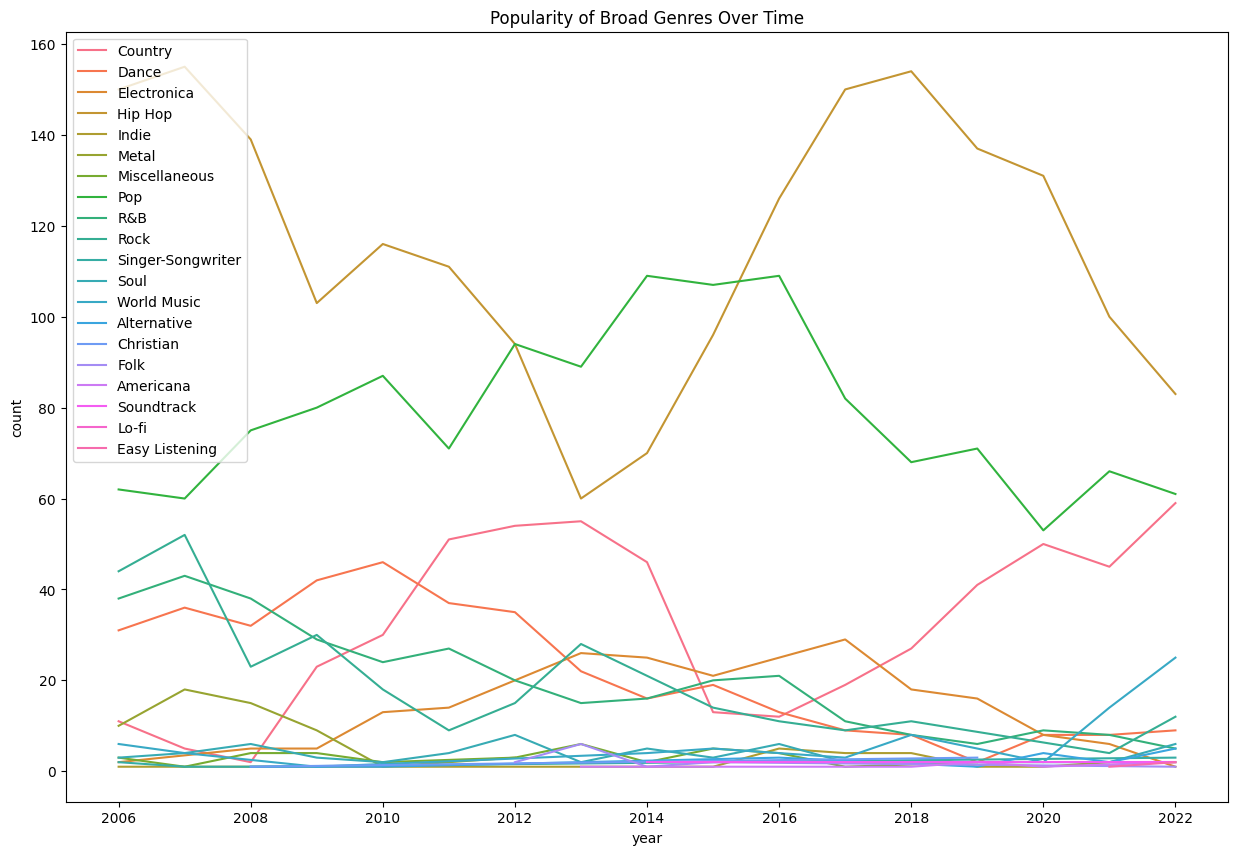

In [ ]:
# Count occurrences of each broad genre per year
genre_counts_per_year = df_split_genre.groupby(['year', 'broad_genre']).size().reset_index(name='count')

plt.figure(figsize=(15,10))
sns.lineplot(data=genre_counts_per_year, x='year', y='count', hue='broad_genre')
plt.title('Popularity of Broad Genres Over Time')
plt.legend(loc='upper left')
plt.show()

## Artist Dominance
In the ever-evolving world of music, chart dominance offers a unique lens into understanding both artistic prowess and audience preferences. Charting artist dominance across years not only illustrates which musicians resonated most with the public during a specific timeframe but also hints at broader socio-cultural or industry shifts that propelled their music to the forefront. By plotting a bar graph detailing artist dominance, we get a visual representation of musical powerhouses from 2006 to 2022. For instance, artists like T-Pain, Beyonce, and Drake have had notable peaks, shedding light on their influence and the musical landscape of their peak years. Such a visualization prompts deeper questions – what did Ke$ha offer in 2010 that made her a standout? Why was Bad Bunny so resonant in 2022? This exploration not only celebrates these artists' achievements but also encourages a deeper dive into the music industry's intricacies and the socio-cultural zeitgeist they tapped into.

In [ ]:
df_split_artist

In [ ]:
# Count the number of songs per artist per year
artist_counts_per_year = df_split_artist.groupby(['year', 'split_artist']).size().reset_index(name='count')

# For each year, get the artist with the most songs
top_artists_per_year = artist_counts_per_year.loc[artist_counts_per_year.groupby('year')['count'].idxmax()]
top_artists_per_year

,year,split_artist,count
15,2006,Chris Brown,4
100,2007,Akon,6
265,2008,T-Pain,7
289,2009,Beyonce,5
404,2010,Ke$ha,5
515,2011,Lil Wayne,5
619,2012,Rihanna,6
648,2013,Bruno Mars,3
775,2014,Iggy Azalea,4
904,2015,Meghan Trainor,5


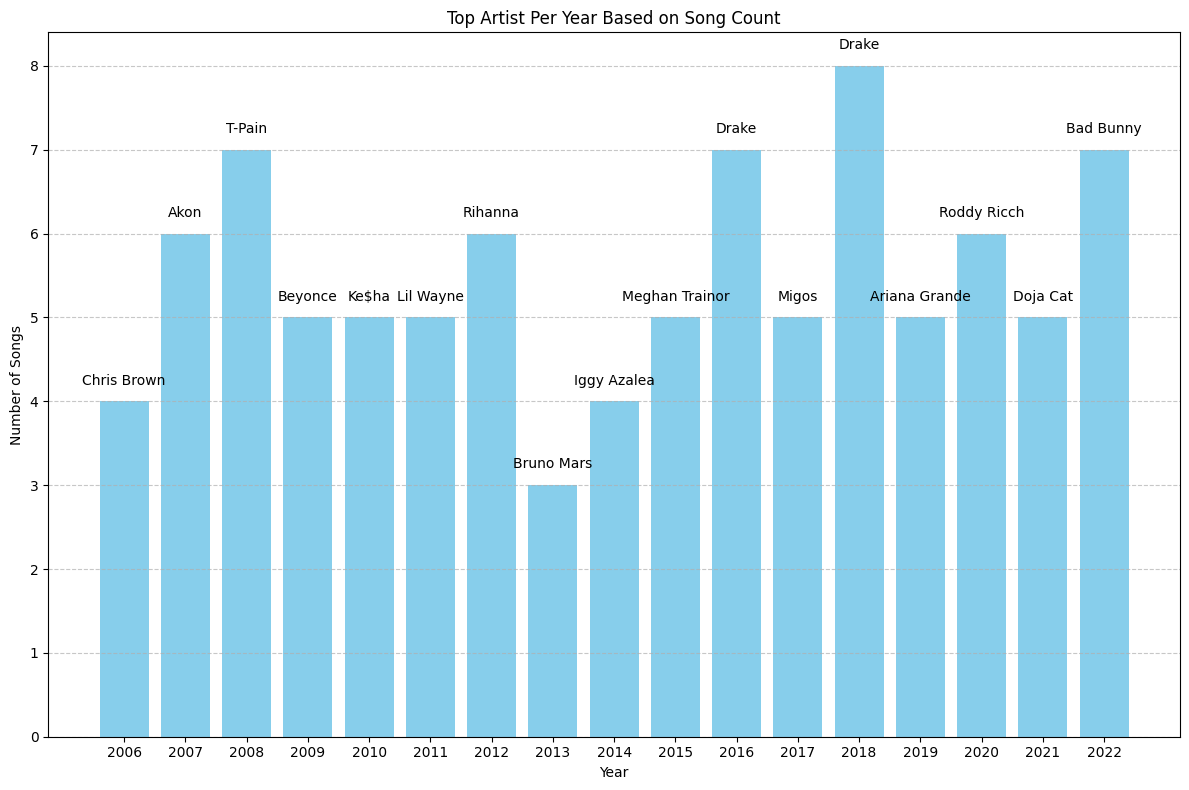

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(top_artists_per_year['year'], top_artists_per_year['count'], color='skyblue')
plt.xticks(top_artists_per_year['year'])
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.title('Top Artist Per Year Based on Song Count')

# Adding artist names as labels on top of the bars
for index, row in top_artists_per_year.iterrows():
    plt.text(row['year'], row['count'] + 0.2, row['split_artist'], ha='center')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

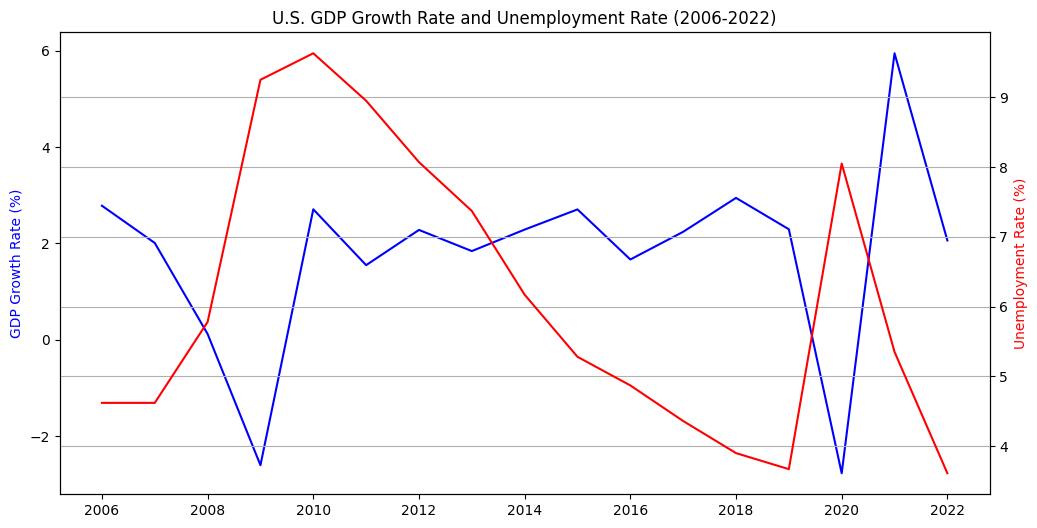

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# First Y-axis for GDP
plt.plot(df_economy['year'], df_economy['GDP growth (%)'], label='GDP Growth Rate', color='blue')
plt.ylabel('GDP Growth Rate (%)', color='blue')

# Create a second Y-axis for Unemployment Rate
ax2 = plt.gca().twinx()
ax2.plot(df_economy['year'], df_economy['unemployment Rate (%)'], label='Unemployment Rate', color='red')
ax2.set_ylabel('Unemployment Rate (%)', color='red')

# Setting X-axis label and title
plt.xlabel('Year')
plt.title('U.S. GDP Growth Rate and Unemployment Rate (2006-2022)')

plt.grid(True)
plt.show()

## The Music Mood trend

In [ ]:
# Convert mood to numeric
mood_mapping = {
    'Happy': 1,
    'Neutral': 0,
    'Sad': -1
}
df_music['mood_numeric'] = df_music['mood'].map(mood_mapping)

# Calculate the average mood per year
avg_mood_per_year_mean = df_music.groupby('year')['mood_numeric'].mean()

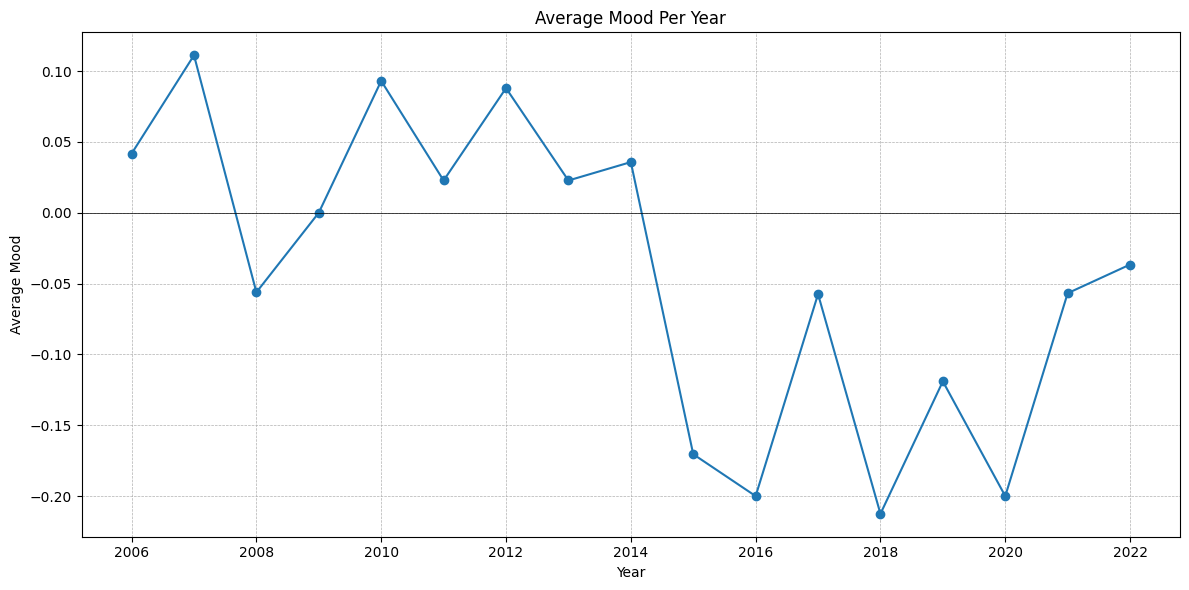

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_economy['year'], avg_mood_per_year_mean, marker='o')
plt.title('Average Mood Per Year')
plt.xlabel('Year')
plt.ylabel('Average Mood')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=0.5)
plt.tight_layout()
plt.show()

## Interpretation Based On the Graphs
2006-2008 (Economic Downturn and R&B/Pop Dominance): [The 2008 economic recession](https://www.forbes.com/advisor/investing/great-recession/#:~:text=The%20Great%20Recession%20of%202008,down%2057%25%20from%20its%20highs) began, one of the worst in U.S. history. Chris Brown, Akon, and T-Pain represent a blend of R&B, pop, and hip-hop. This was a period of feel-good, club-oriented music which might have served as an escapism from the bleak economic reality.

2009-2010 (Recession Aftermath & Empowerment Anthems): Recovery from the recession was slow. Beyonce with tracks like "Single Ladies" delivered empowering anthems. Ke$ha, with her carefree party tracks, offered listeners an escape.

2011-2013 (Steady Recovery & Genre Diversity): The economy was slowly bouncing back. Lil Wayne's hip-hop, Rihanna's blend of R&B, pop, and dance, and Bruno Mars with pop and funk all show a diverse range of genres resonating with audiences.

2014-2015 (Economic Stability & Pop Dominance): The U.S. economy was more stable, with falling unemployment rates. Iggy Azalea and Meghan Trainor represent the pop genre's strength. Their songs, often about self-acceptance and body positivity, reflect a more confident societal mood.

2016-2018 (Political Turmoil & Hip-Hop's Rise): The 2016 election brought political unrest and division. Drake and Migos dominate, reflecting hip-hop's overtaking of rock as the most popular genre in the U.S. Their lyrics often touch upon success, struggles, and authenticity, possibly mirroring a society searching for genuine connections in turbulent times.

2019-2020 (COVID-19 Pandemic & Diverse Pop): The global COVID-19 pandemic led to economic turmoil. Ariana Grande's pop and Roddy Ricch's hip-hop perhaps offer solace in uncertain times. Their dominance shows the need for both reflective (with hip-hop) and uplifting (with pop) music.

2021-2022 (Post-Pandemic & Global Sounds): As the world was grappling with post-pandemic realities, economic recoveries were varied. Doja Cat blends multiple genres, showcasing the eclectic tastes of listeners. Bad Bunny represents the global rise of Latin music, showing the growing influence of international sounds in the U.S. market.

## Hypothesis Testing
### Correlation For GDP Growth Rate

In [ ]:
# Convert the 'year' column to int64 in both DataFrames
genre_counts_per_year['year'] = genre_counts_per_year['year'].astype(int)
df_economy['year'] = df_economy['year'].astype(int)

# Add GDP Growth Rate to the dataFrame
genre_counts_economy_per_year = genre_counts_per_year.merge(df_economy, on='year')


genres = genre_counts_per_year['broad_genre'].unique()
for genre in genres:
    genre_df = genre_counts_economy_per_year[genre_counts_economy_per_year['broad_genre'] == genre]

    # Check if genre_df has at least 2 rows
    if len(genre_df) >= 2:
        correlation, p_value = pearsonr(genre_df['GDP growth (%)'], genre_df['count'])
        print(f"Correlation between GDP Growth Rate and {genre}: {correlation:.2f} / P-value is {p_value:.2f}")
    else:
        print(f"Insufficient data to compute correlation for {genre}")

Correlation between GDP Growth Rate and Country: 0.05 / P-value is 0.84
Correlation between GDP Growth Rate and Dance: -0.22 / P-value is 0.39
Correlation between GDP Growth Rate and Electronica: 0.20 / P-value is 0.45
Correlation between GDP Growth Rate and Hip Hop: -0.07 / P-value is 0.79
Correlation between GDP Growth Rate and Indie: 0.19 / P-value is 0.48
Correlation between GDP Growth Rate and Metal: -0.23 / P-value is 0.66
Correlation between GDP Growth Rate and Miscellaneous: -0.28 / P-value is 0.38
Correlation between GDP Growth Rate and Pop: 0.14 / P-value is 0.60
Correlation between GDP Growth Rate and R&B: -0.20 / P-value is 0.45
Correlation between GDP Growth Rate and Rock: -0.32 / P-value is 0.24
Correlation between GDP Growth Rate and Singer-Songwriter: 0.52 / P-value is 0.37
Correlation between GDP Growth Rate and Soul: -0.21 / P-value is 0.48
Correlation between GDP Growth Rate and World Music: 0.45 / P-value is 0.17
Correlation between GDP Growth Rate and Alternative: 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


### Interpretation
In my analysis, I observed that over the observed period, there are no statistically significant [linear relationships](https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression) between the GDP Growth Rate and the popularity of the various music genres. This means that, based on this analysis, we cannot confidently state that changes in the GDP Growth Rate influence the popularity of these music genres or vice versa.

In [ ]:
# Convert mood to numeric
mood_mapping = {
    'Happy': 1,
    'Neutral': 0,
    'Sad': -1
}
df_music['mood_numeric'] = df_music['mood'].map(mood_mapping)

# Calculate the average mood per year
avg_mood_per_year_mean = df_music.groupby('year')['mood_numeric'].mean()

correlation_gdp_mood, p_value_gdp_mood = pearsonr(df_economy['GDP growth (%)'], avg_mood_per_year_mean)
print(f"Correlation between GDP Growth Rate and mood: {correlation_gdp_mood:.2f} / P-value is {p_value_gdp_mood:.2f}")

Correlation between GDP Growth Rate and mood: 0.14 / P-value is 0.59


### Interpretation
While there appears to be a slight positive trend suggesting that songs lean towards a 'happy' mood when the GDP Growth Rate rises, the correlation is weak and not statistically significant. This means we should be cautious about drawing any firm conclusions regarding the relationship between the economy's performance and the mood of popular songs.

### Correlation For Unemployment Rate

In [ ]:
genres = genre_counts_per_year['broad_genre'].unique()
for genre in genres:
    genre_df = genre_counts_economy_per_year[genre_counts_economy_per_year['broad_genre'] == genre]

    # Check if genre_df has at least 2 rows
    if len(genre_df) >= 2:
        correlation, p_value = pearsonr(genre_df['unemployment Rate (%)'], genre_df['count'])
        print(f"Correlation between Unemployment Rate and {genre}: {correlation:.2f} / P-value is {p_value:.2f}")
    else:
        print(f"Insufficient data to compute correlation for {genre}")

Correlation between Unemployment Rate and Country: 0.29 / P-value is 0.26
Correlation between Unemployment Rate and Dance: 0.67 / P-value is 0.00
Correlation between Unemployment Rate and Electronica: -0.06 / P-value is 0.83
Correlation between Unemployment Rate and Hip Hop: -0.36 / P-value is 0.15
Correlation between Unemployment Rate and Indie: -0.47 / P-value is 0.06
Correlation between Unemployment Rate and Metal: -0.78 / P-value is 0.07
Correlation between Unemployment Rate and Miscellaneous: 0.26 / P-value is 0.41
Correlation between Unemployment Rate and Pop: 0.15 / P-value is 0.55
Correlation between Unemployment Rate and R&B: 0.23 / P-value is 0.38
Correlation between Unemployment Rate and Rock: -0.01 / P-value is 0.97
Correlation between Unemployment Rate and Singer-Songwriter: -0.73 / P-value is 0.16
Correlation between Unemployment Rate and Soul: -0.11 / P-value is 0.70
Correlation between Unemployment Rate and World Music: -0.49 / P-value is 0.13
Correlation between Unempl

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


### Interpretation
The analysis suggests a few potential patterns between the Unemployment Rate and the popularity of certain music genres. Specifically, the Dance genre has a strong and statistically significant positive correlation with unemployment, hinting that Dance music's popularity might increase in times of higher unemployment.

However, for most genres, while there are observable correlations (both positive and negative), they aren't statistically significant. This means that while there might be some trends, they could also occur by chance.

It's essential to approach these findings with caution, as correlation does not imply causation. Additional studies or data might be needed to understand the underlying reasons for these patterns.

In [ ]:
correlation_gdp_mood, p_value_gdp_mood = pearsonr(df_economy['unemployment Rate (%)'], avg_mood_per_year_mean)
print(f"Correlation between Unemployment Rate and mood: {correlation_gdp_mood:.2f} / P-value is {p_value_gdp_mood:.2f}")

Correlation between Unemployment Rate and mood: 0.39 / P-value is 0.12


### Interpretation
When examining the relationship between Unemployment Rate and the weighted mood (where 'happy' scores 1, 'neutral' scores 0, and 'sad' scores -1), we found a moderate positive correlation of 0.39. This suggests that as unemployment increases, the general mood of top songs, as represented by our weighting, tends to be more positive. However, with a p-value of 0.12, this observed relationship is not statistically significant at the conventional 0.05 threshold. This means that while there's a trend, we cannot confidently assert that the observed correlation isn't due to chance. As always, it's essential to remember that correlation does not infer causation, and other factors might be influencing this observed trend.

# Machine Learning

I aggregate or group the merged data by year to calculate the average mood_numeric value. This average represents the "net mood" of songs for that year. For example, if the average mood_numeric value for a year is close to +1, it suggests that a significant proportion of songs from that year were happy. Conversely, values close to -1 would suggest more sad songs.

I set up a [linear regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). This model tries to learn a linear relationship between the features (GDP Rate and Unemployment Rate) and the target variable (mood_numeric).
The data is split into training and test sets. The model learns from the training set.

After training, the model's predictions on the test set are compared to the actual values to compute the Mean Squared Error ([MSE](https://statisticsbyjim.com/regression/mean-squared-error-mse/)). The MSE provides a measure of how well the model's predictions match the actual data. Lower values are better.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Merge dataframes on year
merged_data = df_music.merge(df_economy, on='year')

# Calculate proportion of happy songs per year
grouped_data = merged_data.groupby('year').agg({
    'GDP growth (%)': 'first',
    'unemployment Rate (%)': 'first',
    'mood_numeric': 'mean'
}).reset_index()

# Features and target
X = grouped_data[['GDP growth (%)', 'unemployment Rate (%)']]
y = grouped_data['mood_numeric']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate and print the error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Predict proportion of happy songs for a new GDP Rate and Unemployment Rate
gdp_rate = 2.5  # example value
unemployment_rate = 5.0  # example value

predicted_happy_proportion = model.predict([[gdp_rate, unemployment_rate]])
print(f"Predicted proportion of happy songs for GDP Rate {gdp_rate} and Unemployment Rate {unemployment_rate}: {predicted_happy_proportion[0]}")


Mean Squared Error: 0.018437208194942795
Predicted proportion of happy songs for GDP Rate 2.5 and Unemployment Rate 5.0: -0.07709018491389735


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Interpretation
Mean Squared Error (MSE): The Mean Squared Error (MSE) measures the average squared differences between the predicted and actual values. In most contexts, a lower MSE is preferred as it indicates a better fit to the data. However, without knowing the MSE of other models or baselines, it's hard to assess whether this is good or not for this particular dataset.

Predicted Proportion: The predicted value of approximately -0.077 for a GDP Rate of 2.5 and an Unemployment Rate of 5.0 suggests that in an economic scenario with these rates, the net mood of songs leans slightly towards the "sad" side. The value is closer to 0 (neutral) than -1 (fully sad), meaning the songs might be more neutral with a hint of sadness. In essence, based on my model and the data I've fed into it, in an economic environment with a 2.5% GDP Rate and a 5.0% Unemployment Rate, the trend in music would lean slightly towards a sadder or more neutral mood rather than a happy one.

this code aims to investigate whether there's a measurable link between a country's economic health and the mood of its popular music. The idea is grounded in the belief that socio-economic conditions can influence culture, and by extension, the kind of music that resonates with the public. By building and evaluating this model, you're exploring this potential connection in a data-driven manner.


# Conclusion
The period from 2006 to 2022 witnessed notable shifts in the U.S. economy, with defining moments like the Great Recession and the economic repercussions of the 2020 global pandemic. Alongside these economic ebbs and flows, music trends displayed corresponding mood shifts. During economic downturns, the music charts leaned towards tracks with sadder or neutral moods, while times of economic stability or growth saw a rise in more upbeat songs.

Using a linear regression model, the analysis reinforced the observed trends, showcasing a potential linkage between the health of the U.S. economy and musical moods. With a reasonable MSE of 0.0184, the model predicted, for instance, that in an economic setting with a 2.5% GDP Rate and 5.0% Unemployment Rate, music would lean 7.71% sadder. This suggests that music, as an expressive medium, might be reflecting society's sentiments during varied economic times.

However, it's crucial to approach these findings with caution. While there appears to be a correlation, it doesn't automatically denote causation. Music trends are influenced by myriad factors, with the economy being just one among them. Future investigations could delve deeper, integrating variables like technological influences or global events. Nonetheless, the present analysis paints a compelling picture of how societal economic conditions and musical moods might be intertwined, shedding light on the intricate dynamics between financial well-being and cultural outputs.